# Colab환경에서 실행해야합니다.

In [1]:
%%capture
# Normally using pip install unsloth is enough

# Temporarily as of Jan 31st 2025, Colab has some issues with Pytorch
# Using pip install unsloth will take 3 minutes, whilst the below takes <1 minute:
!pip install --no-deps langchain langchain-community faiss-cpu sentence-transformers
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

# Unsloth로 학습시킨 model, tokenizer와 뉴스 vectorestore 로드

In [2]:
# from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline
from transformers import pipeline
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

# 모델과 토크나이저 로드
llm_pipeline = pipeline('text-generation', model='drive/MyDrive/trained_model', tokenizer='drive/MyDrive/trained_model', max_new_tokens=256, num_return_sequences=1, temperature=0.01, top_p=0.9, device_map='auto')
llm = HuggingFacePipeline(pipeline=llm_pipeline)

# 벡터 스토어 로드
embedding_model = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')
vectorstore = FAISS.load_local('drive/MyDrive/faiss_news_index', embedding_model, allow_dangerous_deserialization=True)

# RAG를 적용하여 QA 실행

In [4]:
query = '파월 의장의 금리 정책 발언 요약해줄래?'
retriever = vectorstore.as_retriever(search_kwargs={'k':1})
docs = retriever.get_relevant_documents(query)

# context = '\n\n'.join([doc.page_content for doc in docs])
final_prompt = f'다음 정보를 참고하여 질문에 답하세요 : \n\n{docs[0]}\n\n질문: {query}\n답변:'
response = llm(final_prompt)

# print(response)

# Generate 결과

In [32]:
print('1. Unsloth/gemma-2-9b에 BCCard 데이터 파인 튜닝한 버전')
print()
print('''질문 : 파월 의장의 금리 정책 발언 요약해줄래?
답변 : 파월 의장은 금리 인상을 계속할 것이라고 발언했으며, 이는 경제 성장과 인플레이션을 조정하기 위한 조치로 간주된다. 그는 또한, 금리 인상이 경제에 미치는 영향을 면밀히 모니터링할 것이라고 밝혔다.''')
print()
print('2. Unsloth/gemma-2-9b에 BCCard 데이터 파인 튜닝한 버전 + RAG 적용')
print()
print('질문 :', query)
print('답변 :', end='')
for i, s in enumerate(response.split('\n답변: ')[-1]):
  print(s, end='')
  if i % 130 == 129:
    print()
else:
  print()
string = '제롬 파월 연준 의장은 상원 청문회에서 추가 금리 인하를 서두를 필요가 없다고 재차 강조했습니다.  그는 현재의 통화정책이 이전보다 덜 제약적이며 경제가 여전히 강하다는 점을 근거로 들었습니다.  금리 인하를 너무 서두르면 인플레이션 둔화에 악영향을 미칠 수 있고, 반대로 너무 늦추면 경제 활동과 고용이 과도하게 위축될 수 있다는 점을 우려했습니다.  트럼프 대통령의 관세 정책에 대해서는 연준의 관할이 아니라고 언급하며 중립적인 입장을 유지했습니다. 다만, 관세가 인플레이션 상승으로 이어질 수 있다는 점은 인정했습니다.  결론적으로 파월 의장은 현재의 금리 수준을 장기간 유지할 가능성이 높음을 시사했으며,  경제 상황과 인플레이션 움직임을 지켜보며 신중하게 통화정책을 운영하겠다는 입장을 보였습니다.  파월 의장의 발언에도 불구하고 시장의 반응은 크지 않았습니다.'
print()
print('3. Gemini-1.5-flash의 답변')
print()
print('질문 : 아래 내용을 보고 파월 의장의 금리 정책 발언 요약해줘 {texts}')
for i, s in enumerate(string):
  print(s, end='')
  if i % 130 == 129:
    print()

### RAG에 사용된 데이터 -> 2025-02-12의 네이버 해외증시 뉴스 크롤링한 text   
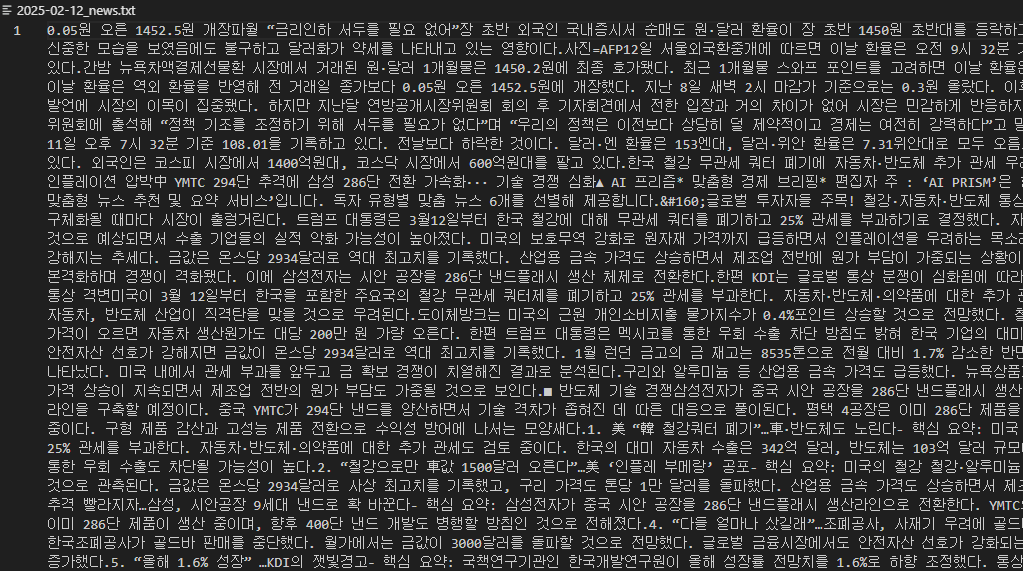

## 진행 중 문제

langchain의 RetrievalQA를 통해서 RAG QA를 진행해보려했으나    
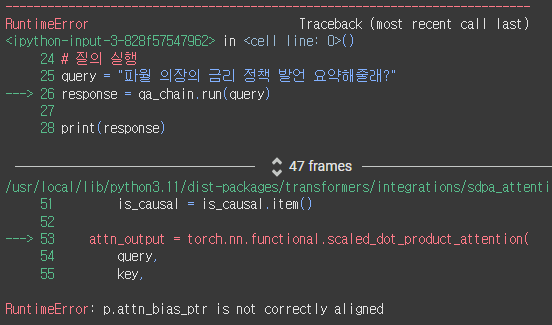   
에러 발생, 해결 실패로 인해 빼고 llm에서 직접 RAG데이터를 쓰는 방식으로 진행   
또한 실행 시간 단축 필요해보임